In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib.pyplot inline

UsageError: Line magic function `%matplotlib.pyplot` not found.


## 1. Import Data

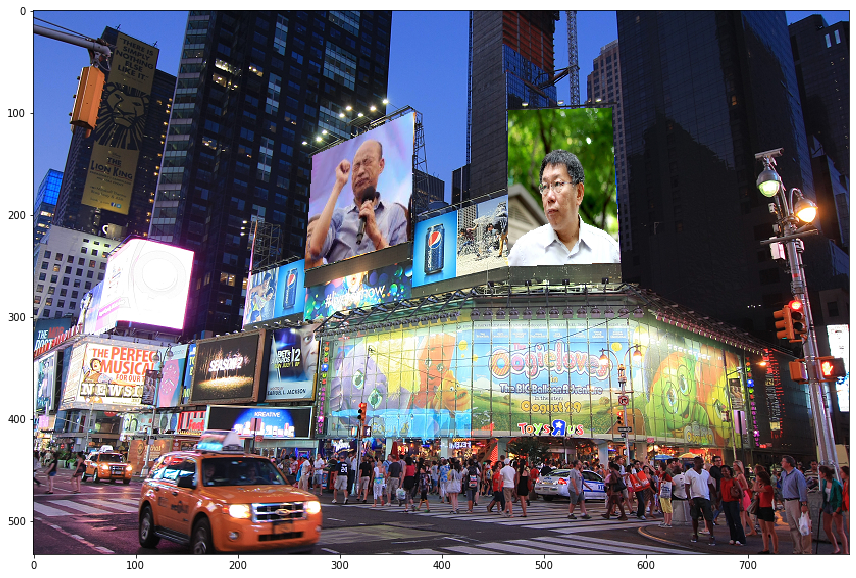

In [21]:
canvas = cv2.imread('TimeSequare.png')
canvas2 = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(canvas2)

In [22]:
screen_corner1 = np.load('1.npy')
screen_corner2 = np.load('2.npy')

## 2. Backward Warpping
Get image of KP & Han by backward warpping

In [23]:
output = np.zeros((300, 300, 3))
h, w, ch = output.shape
img_corner = np.array([[0, 0], [w-1, 0], 
                       [0, h-1], [w-1, h-1]])

### 2.1 Solving for homographies

In [24]:
def get_homograph(u,v):
    A = np.array([[u[0][0], u[0][1], 1, 0, 0, 0, -1 * u[0][0] * v[0][0], -1 * u[0][1] * v[0][0]],
                  [0, 0, 0, u[0][0], u[0][1], 1, -1 * u[0][0] * v[0][1], -1 * u[0][1] * v[0][1]],
                  [u[1][0], u[1][1], 1, 0, 0, 0, -1 * u[1][0] * v[1][0], -1 * u[1][1] * v[1][0]],
                  [0, 0, 0, u[1][0], u[1][1], 1, -1 * u[1][0] * v[1][1], -1 * u[1][1] * v[1][1]],
                  [u[2][0], u[2][1], 1, 0, 0, 0, -1 * u[2][0] * v[2][0], -1 * u[2][1] * v[2][0]],
                  [0, 0, 0, u[2][0], u[2][1], 1, -1 * u[2][0] * v[2][1], -1 * u[2][1] * v[2][1]],
                  [u[3][0], u[3][1], 1, 0, 0, 0, -1 * u[3][0] * v[3][0], -1 * u[3][1] * v[3][0]],
                  [0, 0, 0, u[3][0], u[3][1], 1, -1 * u[3][0] * v[3][1], -1 * u[3][1] * v[3][1]]
                ])
    
    b = np.array([[v[0][0]],
                  [v[0][1]],
                  [v[1][0]],
                  [v[1][1]],
                  [v[2][0]],
                  [v[2][1]],
                  [v[3][0]],
                  [v[3][1]]
                ])
    
    tmp = np.dot(np.linalg.inv(A), b)
    
    H = np.array([[tmp[0][0], tmp[1][0], tmp[2][0]],
                  [tmp[3][0], tmp[4][0], tmp[5][0]],
                  [tmp[6][0], tmp[7][0], 1]
                 ])
    
    return H

In [25]:
def interpolation(img, new_x, new_y):
    fx = round(new_x - int(new_x), 2)
    fy = round(new_y - int(new_y), 2)

    p = np.zeros((3,))
    p += (1 - fx) * (1 - fy) * img[int(new_y), int(new_x)]
    p += (1 - fx) * fy * img[int(new_y) + 1, int(new_x)]
    p += fx * (1 - fy) * img[int(new_y), int(new_x) + 1]
    p += fx * fy * img[int(new_y) + 1, int(new_x) + 1]

    return p

In [26]:
u = img_corner
v = screen_corner1
N = u.shape[0]

In [27]:
homography_matrix = get_homograph(u,v)

In [28]:
for y in range(h):
    for x in range(w):
        new_pos = np.dot(homography_matrix, np.array([[x, y, 1]]).T)
        new_x, new_y = new_pos[0][0] / new_pos[2][0], new_pos[1][0] / new_pos[2][0]
        res = interpolation(canvas, new_x, new_y)
        output[y][x] = res

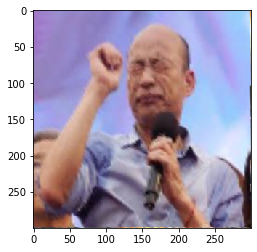

In [29]:
cv2.imwrite('Han.png', output)
output2 = cv2.imread('Han.png')
output21 = cv2.cvtColor(output2, cv2.COLOR_BGR2RGB)
plt.imshow(output21)

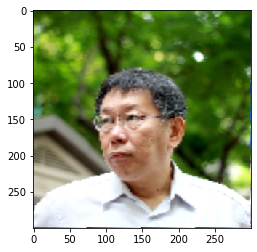

In [31]:
u = img_corner
v = screen_corner2
N = u.shape[0]
homography_matrix = get_homograph(u,v)

for y in range(h):
    for x in range(w):
        new_pos = np.dot(homography_matrix, np.array([[x, y, 1]]).T)
        new_x, new_y = new_pos[0][0] / new_pos[2][0], new_pos[1][0] / new_pos[2][0]
        res = interpolation(canvas, new_x, new_y)
        output[y][x] = res

cv2.imwrite('Han.png', output)
output3 = cv2.imread('Han.png')
output31 = cv2.cvtColor(output3, cv2.COLOR_BGR2RGB)
plt.imshow(output31)        

## 3. Forward Warpping

### 3.1 Put Han's photo in KP location

In [32]:
h, w, ch = output2.shape
orig_corner = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
orig_corner

array([[  0,   0],
       [299,   0],
       [  0, 299],
       [299, 299]])

In [33]:
u=orig_corner #source corner
v=screen_corner2 # target corner

In [34]:
matrix = get_homograph(u,v)

for i in range(h):
    for j in range(w):
        tmp2 = np.dot(matrix, np.array([[j, i, 1]]).T)
        x, y = int(tmp2[0][0] / tmp2[2][0]), int(tmp2[1][0] / tmp2[2][0])
        canvas[y][x] = output2[i][j]

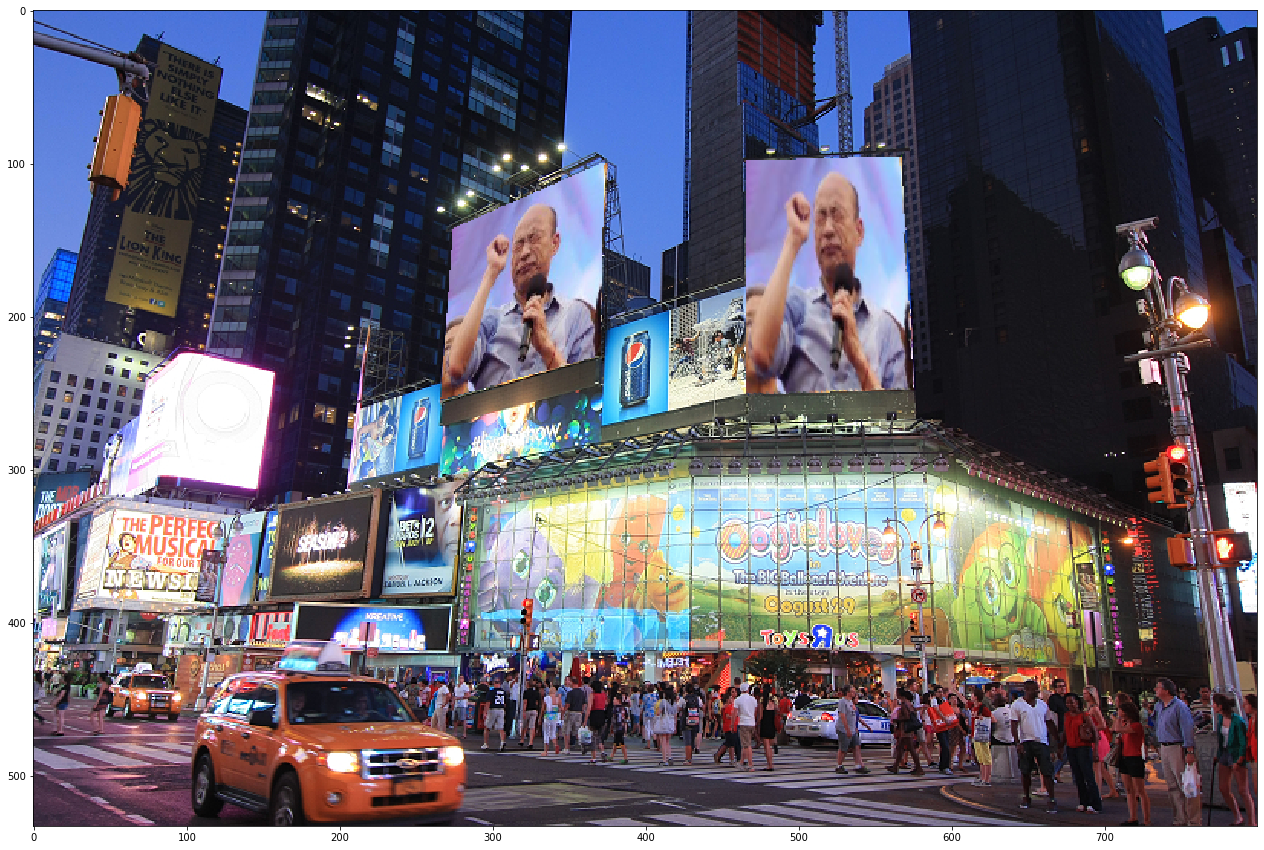

In [35]:
canvas2 = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(30,15))
plt.imshow(canvas2)

### 3.2 Put KP's photo in Han location

In [36]:
h, w, ch = output3.shape
orig_corner = np.array([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
u=orig_corner #source corner
v=screen_corner1 # target corner

matrix = get_homograph(u,v)

for i in range(h):
    for j in range(w):
        tmp2 = np.dot(matrix, np.array([[j, i, 1]]).T)
        x, y = int(tmp2[0][0] / tmp2[2][0]), int(tmp2[1][0] / tmp2[2][0])
        canvas[y][x] = output3[i][j]

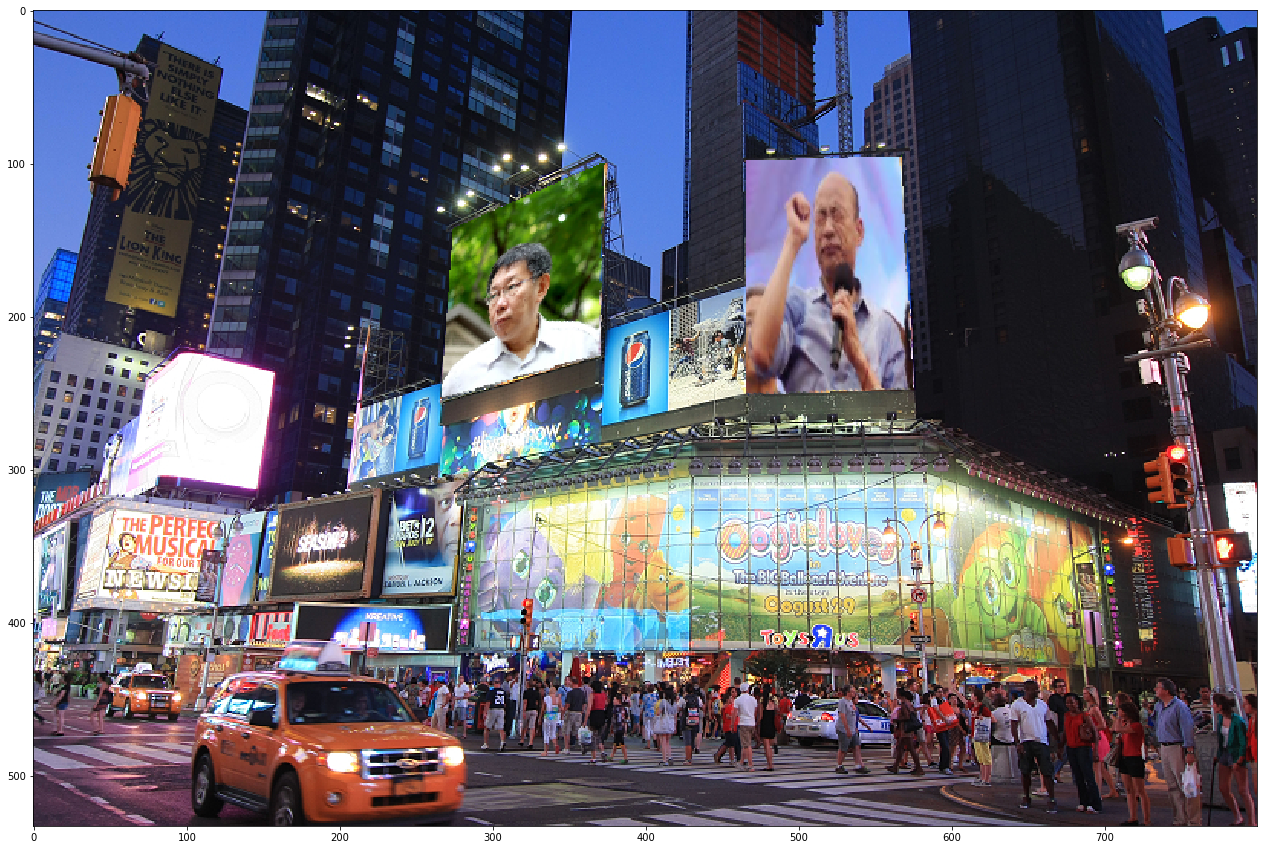

In [37]:
canvas2 = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(30,15))
plt.imshow(canvas2)